In [1]:
import json
import lightgbm as lgbm
import pandas as pd
import scipy.io as scio
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'

# 读入数据

In [2]:
data_path = r"../data/data.mat"
print("load data")
data = scio.loadmat(data_path)

datainptrain = data['datainptrain']
dataouttrain = data['dataouttrain']
datainptest = data['datainptest']
dataouttest = data['dataouttest']

'''
X_train = datainptrain
y_train = dataouttrain
X_test = datainptest
y_test = dataouttest

'''
X_test = datainptrain
y_test = dataouttrain
X_train = datainptest
y_train = dataouttest

load data


In [3]:
print('X_train.shape: ',X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (4165, 19)
y_train.shape:  (4165, 5)
X_test.shape:  (830, 19)
y_test.shape:  (830, 5)


# 把onehot标签修改为1、2、3、4、5

In [4]:
#change labels from one-hot to number
y_train_temp = y_train
y_test_temp = y_test
del y_train
del y_test
y_train = [[] for i in range(y_train_temp.shape[0])]
for i in range(y_train_temp.shape[0]):
    if list(y_train_temp[i]) == [1,0,0,0,0]:
        y_train[i] = 0
    if list(y_train_temp[i]) == [0,1,0,0,0]:
        y_train[i] = 1
    if list(y_train_temp[i]) == [0,0,1,0,0]:
        y_train[i] = 2
    if list(y_train_temp[i]) == [0,0,0,1,0]:
        y_train[i] = 3    
    if list(y_train_temp[i]) == [0,0,0,0,1]:
        y_train[i] = 4

y_test = [[] for i in range(y_test_temp.shape[0])]
for i in range(y_test_temp.shape[0]):
    if list(y_test_temp[i]) == [1,0,0,0,0]:
        y_test[i] = 0
    if list(y_test_temp[i]) == [0,1,0,0,0]:
        y_test[i] = 1
    if list(y_test_temp[i]) == [0,0,1,0,0]:
        y_test[i] = 2
    if list(y_test_temp[i]) == [0,0,0,1,0]:
        y_test[i] = 3    
    if list(y_test_temp[i]) == [0,0,0,0,1]:
        y_test[i] = 4
        


X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [5]:
print('X_train.shape: ',X_train.shape,'type of X_train: ',type(X_train))
print('y_train.shape: ',y_train.shape,'type of y_train: ',type(y_train))
print('X_test.shape: ',X_test.shape,'type of X_test: ',type(X_test))
print('y_test.shape: ',y_test.shape,'type of y_test: ',type(y_test))

X_train.shape:  (4165, 19) type of X_train:  <class 'pandas.core.frame.DataFrame'>
y_train.shape:  (4165, 1) type of y_train:  <class 'pandas.core.frame.DataFrame'>
X_test.shape:  (830, 19) type of X_test:  <class 'pandas.core.frame.DataFrame'>
y_test.shape:  (830, 1) type of y_test:  <class 'pandas.core.frame.DataFrame'>


# 打乱数据

In [6]:
full_train = np.concatenate((X_train,y_train),axis=1)
np.random.shuffle(full_train)
X_train = full_train[:,0:19]
y_train = full_train[:,19:]
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [7]:
print('X_train.shape: ',X_train.shape,'type of X_train: ',type(X_train))
print('y_train.shape: ',y_train.shape,'type of y_train: ',type(y_train))
print('X_test.shape: ',X_test.shape,'type of X_test: ',type(X_test))
print('y_test.shape: ',y_test.shape,'type of y_test: ',type(y_test))

X_train.shape:  (4165, 19) type of X_train:  <class 'pandas.core.frame.DataFrame'>
y_train.shape:  (4165, 1) type of y_train:  <class 'pandas.core.frame.DataFrame'>
X_test.shape:  (830, 19) type of X_test:  <class 'pandas.core.frame.DataFrame'>
y_test.shape:  (830, 1) type of y_test:  <class 'pandas.core.frame.DataFrame'>


# 特征降维
lightgbm在高维稀疏的数据集上表现不出优势

# lightgbm模型构建

In [8]:
#直接调用LightGBM内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
import json
def modelfit(params, alg, X_train, y_train, early_stopping_rounds=10):
    lgbm_params = params.copy()
    lgbm_params['num_class'] = 5
    
    #直接调用LightGBM，而非sklarn的wrapper类
    lgbmtrain = lgbm.Dataset(X_train, y_train, silent=True)
    
    cv_result = lgbm.cv(
        lgbm_params, lgbmtrain, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='multi_logloss',
        early_stopping_rounds=early_stopping_rounds,show_stdv=True,seed=0)
    # note: cv_results will look like: {"multi_logloss-mean": <a list of historical mean>,
    # "multi_logloss-stdv": <a list of historical standard deviation>}
    print('best n_estimators:', len(cv_result['multi_logloss-mean']))
    print('best cv score:', cv_result['multi_logloss-mean'][-1])
    #cv_result.to_csv('lgbm1_nestimators.csv', index_label = 'n_estimators')
    json.dump(cv_result, open('lgbm_1.json', 'w'))
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = len(cv_result['multi_logloss-mean']))
    alg.fit(X_train, y_train)

In [9]:
params = {'boosting_type': 'gbdt', 
          'objective': 'multiclass', 
          'nthread': -1, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 50, 
          'max_depth': 6,
          'max_bin': 127, 
          'subsample_for_bin': 50000,
          'subsample': 0.8, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 1, 
          'reg_lambda': 0,
          'min_split_gain': 0.0, 
          'min_child_weight': 1, 
          'min_child_samples': 20, 
          'scale_pos_weight': 1}

lgbm1 = lgbm.sklearn.LGBMClassifier(num_class= 5, n_estimators=1000, seed=0, **params)

modelfit(params,lgbm1, X_train, y_train)

/root/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


best n_estimators: 187
best cv score: 0.01148155341460718


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


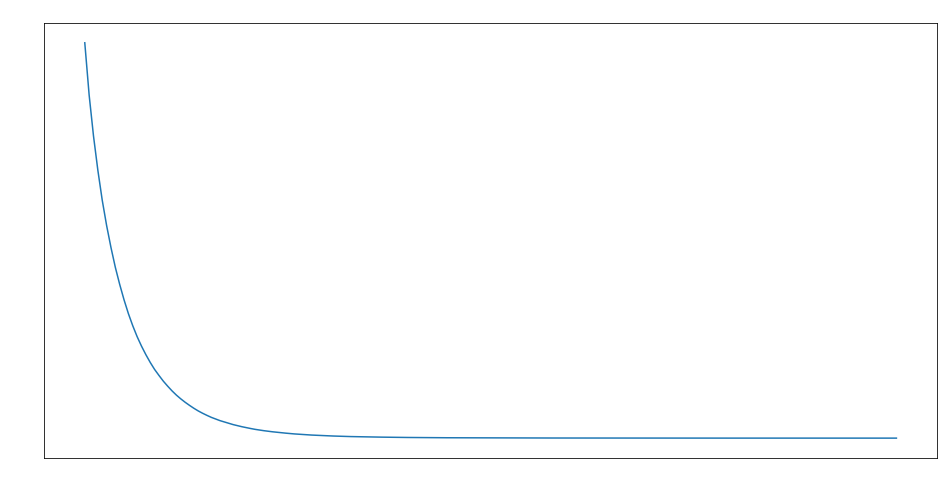

In [12]:
#cv_result = pd.DataFrame.from_csv('lgbm1_nestimators.csv')
cv_result = pd.read_json("lgbm_1.json")

# plot
test_means = cv_result['multi_logloss-mean']
#test_stds = cv_result['multi_logloss-std'] 

x_axis = range(0, cv_result.shape[0])
plt.figure()

plt.plot(x_axis, test_means) 
plt.title("LightGBM n_estimators vs Log Loss",color='w')
plt.xlabel( 'n_estimators',color='w' )
plt.ylabel( 'Log Loss',color='w' )
plt.savefig( 'lgbm1_n_estimators.png')

plt.rcParams['figure.figsize'] = 16,8
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.show()

In [11]:
y_pred = lgbm1.predict(X_test)
accuracy_pred = accuracy_score(y_pred,y_test)
print("准确率： ",accuracy_pred)

准确率：  0.9987951807228915


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
